In [1]:
# Optical Mark Recognition using OpenCV

In [2]:
# Image Processing Methods used in this Mini-Project :
#  1) Thresholding and Grayscaling
#  2) Guassian Blurring
#  3) Canny Edge Detection (Laplacian)
#  4) Contour Extraction
#  5) Four Point Transform
#  6) Otsu's Global Thresholding

In [3]:
# import the necessary packages

from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
 
# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 3, 2: 0, 3: 2, 4: 1}

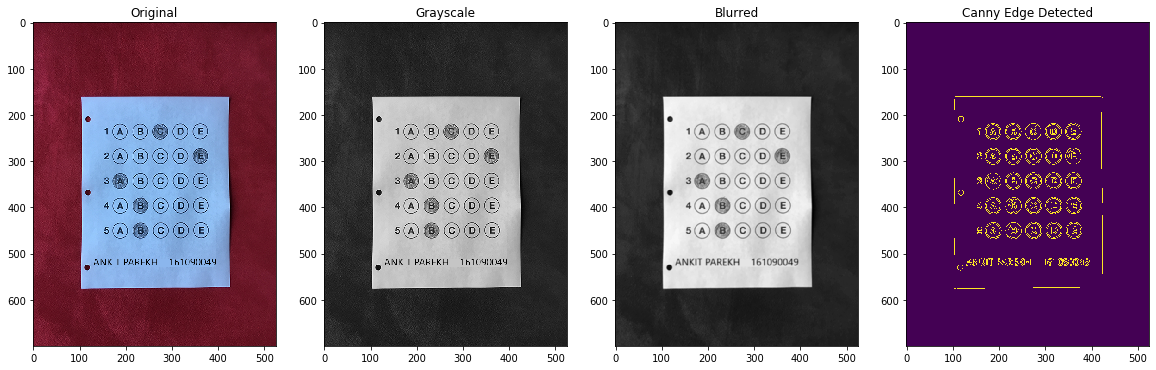

In [4]:
# load the image, convert it to grayscale, blur it slightly, 
# then find edges using Canny Edge detection
import matplotlib.pyplot as plt
%matplotlib inline
image = cv2.imread("/Users/Ankit/Documents/GitHub/DIP MINI PROJECT/test_02.png")
image = image[:,:,::-1]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

# Plot the converted images
fig, (ax1, ax2, ax3 ,ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 20))
ax1.imshow(image)
ax1.set_title("Original")
ax2.imshow(gray,cmap='gray')
ax2.set_title("Grayscale")
ax3.imshow(blurred,cmap='gray')
ax3.set_title("Blurred")
ax4.imshow(edged)
ax4.set_title("Canny Edge Detected")
plt.show()

In [5]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None
 
# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in
    # descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

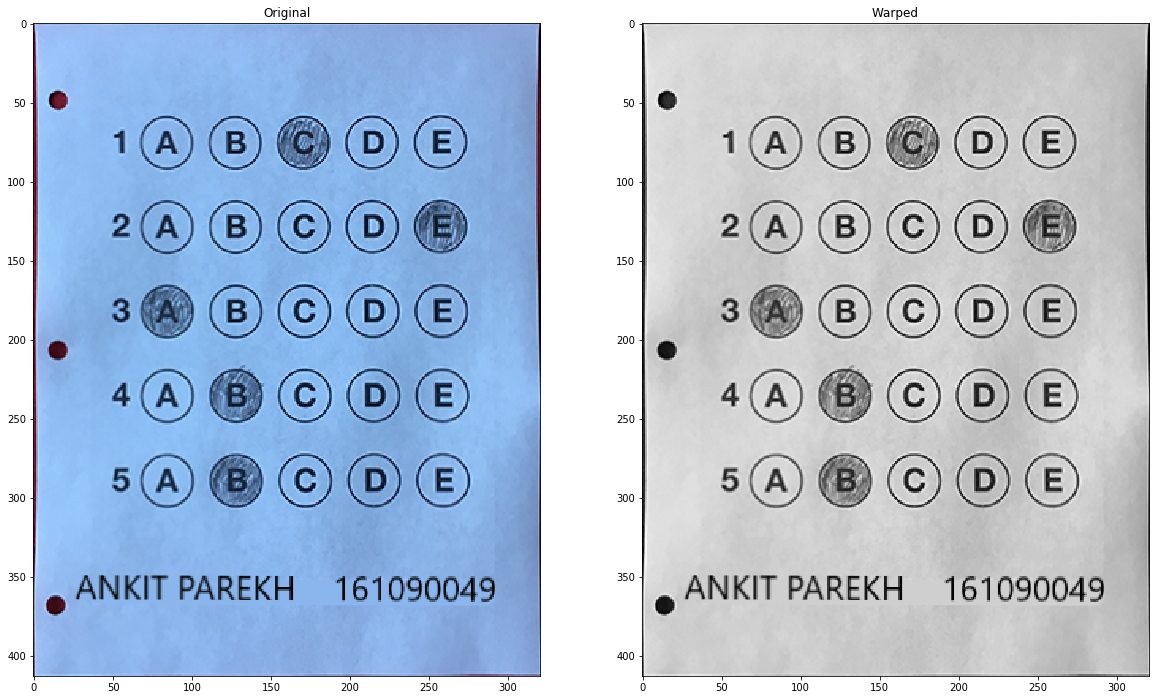

In [6]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

# Plot the converted images
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20))
ax1.imshow(paper)
ax1.set_title("Original")
ax2.imshow(warped,cmap='gray')
ax2.set_title("Warped")
plt.show()

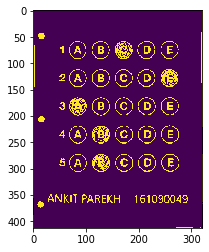

In [7]:
# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [8]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
 
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

In [9]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,
    method="top-to-bottom")[0]
correct = 0
 
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
            # initialize the contour color and the index of the
    # *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]

    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
 
    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

[INFO] score: 40.00%


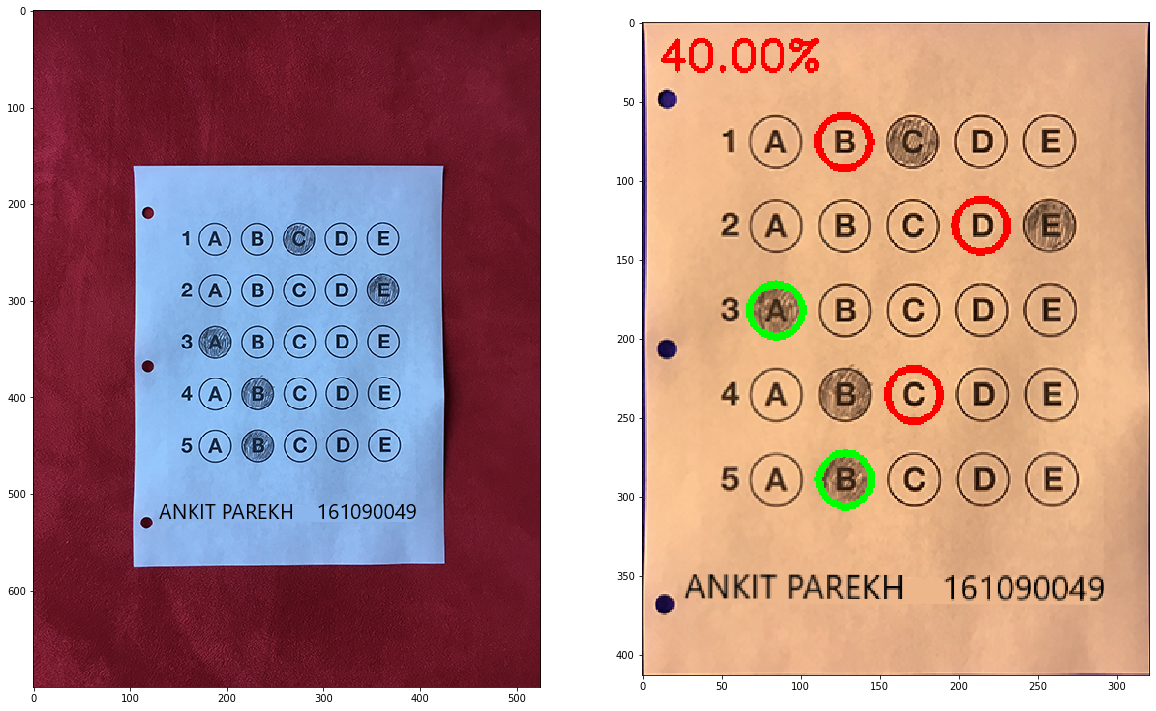

In [10]:
# final evaluation and score 
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
paper = cv2.putText(paper, "{:.2f}%".format(score), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
paper = paper[:,:,::-1]
# plot the original and final evaluated test sheet
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20))
ax1.imshow(image)
ax2.imshow(paper)
plt.show()

In [284]:
# To save the evaluated answer sheet
plt.imsave("/Users/Ankit/Documents/OpenCV/omr/evaluated_test_02.png",paper)